# RASA8 Test 2023-11-2526

### Overview

At UTC 03:21 (local time 8:21pm), we began taking 0.1s exposures and at UTC 03:27 we stopped. This is 6 minutes.

The exposures IDs go from 2994 to 3898 inclusive which from which one might expect 905 images. However,

* images 2994 to 3896 are 903 images each of which is 0.1s in duration, and I moved all but 300 of them to a subfolder named other603
* there is no 3897
* image 3898 is a 30-second exposure and it was taken at UTC 03:28, and I moved it to a sub-folder named 30s

The exposure cadence for the 0.1s exposures is 903 / (6 * 60) = 2.5 frames per second.

The images were unbinned and quarter-subframed. The resulting size is 2072x1411.

Each image is 5.8MB.

No calibration was performed and no filters were used.

The RASA 8 has a focal length of 400mm. The camera pixel pitch is 2.3 microns. The expected plate
scale is 2.3 microns / pixel * 360 * 60 * 60 arcseconds / (2 * pi * 400mm) = 1.19 arcseconds / pixel

### Imports

In [9]:
# If you can get everything in this block of code to work, then likely that you have gotten
# all of your dependencies installed, and you can focus on getting actual code to work.

import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.coordinates import SkyCoord
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa
import twirl

# Imports for Plate-Solving
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from astroquery.astrometry_net import AstrometryNet
import keyring
# You will have to uncomment and execute the following (only once) with your actual astrometry.net API key:
# keyring.set_password('astroquery:astrometry_net', None, '****************')
# Your key is then stored privately in the operating system's keychain. Then be sure to remove your key
# and comment back out the line. After doing those steps, the following should work:
AstrometryNet.api_key = keyring.get_password('astroquery:astrometry_net', None)

### Load Images

In [10]:
# Only the following group of constants should need to be adjusted, typically, from one analysis to the next.
observation_date = '2023-11-2526'
light_exposure = 1 * u.second
BINNING = 1  # No binning
SUBFRAMING = 4  # 1/4 Subframing
UNBINNED_PLATE_SCALE = 1.19  # arcseconds / pixel for Celestron RASA 8 with ZWO ASI 294MM Pro
WIDTH_HEIGHT = (8288, 5644)
BINNED_SUBFRAMED_WIDTH_HEIGHT = tuple([x / BINNING / SUBFRAMING for x in WIDTH_HEIGHT])
plate_scale_raw = UNBINNED_PLATE_SCALE * BINNING
plate_scale = plate_scale_raw * u.arcsec

# NOT SURE ANY OF THE FOLLOWING COMMENTS ABOUT NaNs ARE TRUE FOR QUARTER-SUBFRAMING
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.

fov = np.max(WIDTH_HEIGHT) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value

# directories where the observation and calibration images being analyzed are kept
observation_directory = os.path.join(os.path.expanduser('~'), 'Sessions', observation_date)

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        if pixel_value != pixel_value or pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# Trimmed image reader utility (needed because our images can contain columns of NaNs)

def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    # I AM GOING TO START WITH 0 AS THE ARGUMENT BECAUSE WE MAY NOT NEED TO DELETE COLUMNS
    # DUE TO THE SUBFRAMING
    trimmed_data = delete_last_columns(data, 0)
    img.data = trimmed_data
    return img


In [11]:
light_files = ImageFileCollection(observation_directory).files_filtered(include_path='True')
lights = [trimmed_image_reader(file) for file in light_files]

# the CCDData.read command in the above spits out a gob of warnings which are annoying and not important

Set OBSGEO-Y to -4483128.141 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851244.155 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483128.141 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851244.155 from OBSGEO-[LBH]'.


### Examine Images

In [12]:
# First grab a sample light

sample_light = lights[0]
sample_data = np.asarray(sample_light)

# Median subtract each row to get rid of background

medians = np.median(sample_light, axis=1, keepdims=True)
subtracted = sample_light - medians

In [13]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_light = transform(subtracted)

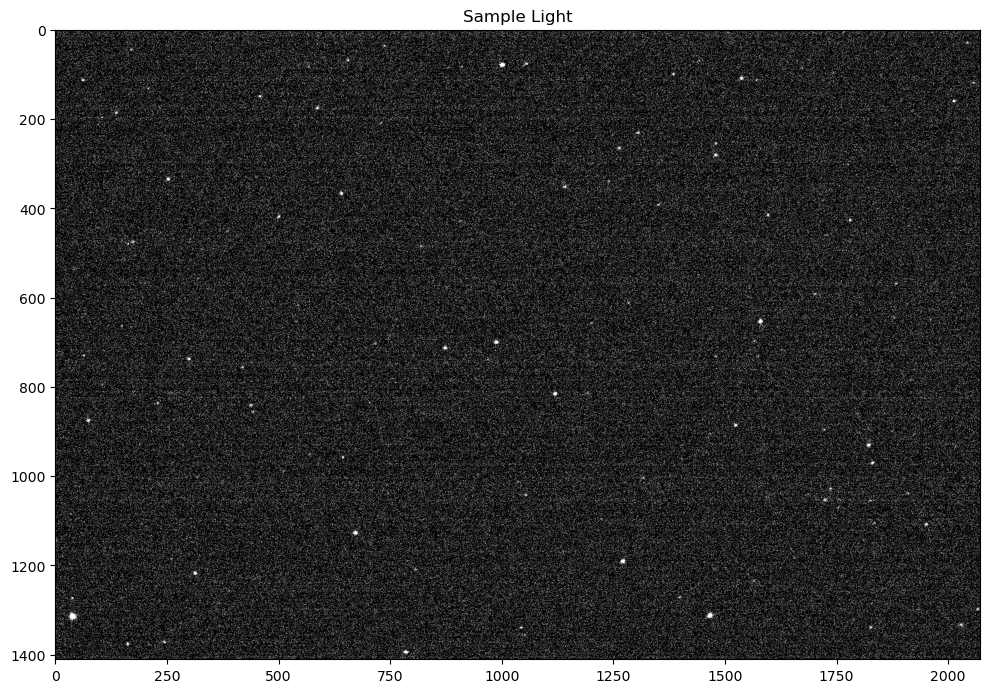

In [14]:
# Display sample

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.imshow(transformed_sample_light, cmap='gray')
axes.set_title("Sample Light")

plt.tight_layout()
plt.show()

### Create and Write the Aligned Lights

Before combining we have to do alignment

In [22]:
footprint = lights[0]

lights_aligned_with_footprint = [aa.register(l, footprint, detection_sigma=2.0) for l in lights]

for j in range(len(lights_aligned_with_footprint)):
    light_header = lights[j].header
    light_aligned_data = lights_aligned_with_footprint[j]
    aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
    aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
    fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)


TypeError: Invalid shape (2, 1411, 2072) for image data

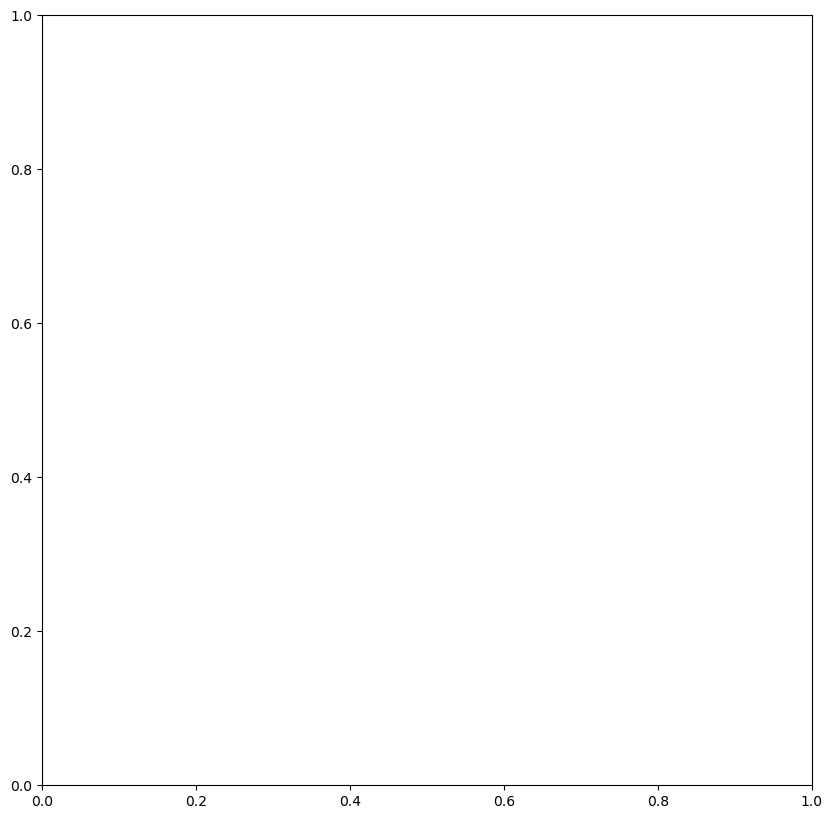

In [23]:
transformed_aligned_light = transform(lights_aligned_with_footprint[100])

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.imshow(transformed_aligned_light, cmap='gray')
axes.set_title("Aligned Light")

plt.tight_layout()
plt.show()

### Read Back in and Stack the Lights

In [17]:
x = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
first_light = fits.open(x[0])
aligned_lights = [CCDData.read(file, unit=u.adu) for file in x]
combined_light = combine(aligned_lights)

Set OBSGEO-Y to -4483128.141 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851244.155 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483128.141 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851244.155 from OBSGEO-[LBH]'.
INFO:astropy:splitting each image into 5 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 5 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


ValueError: too many values to unpack (expected 2)

### Examine the Stacked Lights

In [ ]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

In [ ]:
# Stacked Sloan g' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_G_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

In [ ]:
# Stacked Sloan r' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_R_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

### Plate-Solve and Write the Stacked Images

I tried to follow the twirl package directions for plate solving ([example notebook](https://github.com/lgrcia/twirl/blob/master/docs/notebooks/example.ipynb))
but got an error I couldn't sort out at 

```
gaias = twirl.gaia_radecs(center, fov/2, limit=20)
```

I'm guessing an API key is needed and without it gaias just comes back as an empty list.

In our first-generation notebooks, we used DAOStarFinder, so let's return to that, and then
try the astrometry.net interface for plate-solving.

#### Get Sources with DAOStarFinder then Plate-Solve with AstrometryNet

We are following the [AstrometryNet](https://astroquery.readthedocs.io/en/latest/astrometry_net/astrometry_net.html)
documentation.

In [ ]:
bkg_sigma_list = [mad_std(stacked_data) for stacked_data in stacked_data_list]
daofind = DAOStarFinder(fwhm=4., threshold=5. * bkg_sigma, brightest=100)
sources_list = [daofind(stacked_data) for stacked_data in stacked_data_list]

for sources in sources_list:
    sources.sort('flux')
    sources.reverse()

sources_list[SLOAN_G_FILTER]

In [ ]:
astrometry_net_settings = {
    'scale_units': 'arcsecperpix',
    'scale_type': 'ul',
    'scale_lower': 0.9 * plate_scale_raw,
    'scale_upper': 1.1 * plate_scale_raw,
    'solve_timeout': 120
}

wcs_header_list = [AstrometryNet.solve_from_source_list(sources['xcentroid'],
                                                        sources['ycentroid'],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[0],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[1],
                                                        **astrometry_net_settings) for sources in sources_list]

In [ ]:
# Finally, we write out plate-solved files
stacked_file_list = [os.path.join(observation_directory, "stacked-" + filter + ".fits") for filter in filters]

for i in range(len(filters)):
    stacked_data = stacked_data_list[i]
    representative_header = first_header_list[i]
    wcs_header = wcs_header_list[i]
    representative_header.extend(wcs_header)
    stacked_file = stacked_file_list[i]
    fits.writeto(stacked_file, stacked_data, wcs_header, overwrite=True)


### Then Use PSF Photometry to Determine Relative Magnitudes of Target and Reference Stars

NB: In the files just written, the WCS header (for a given filter) was merged with the *first* FITS
header (for a given filter). This is suspect and needs correcting/augmenting, because the total exposure
duration and the MIDOBS are just those of the first image (for a given filter). If we in fact have 30 60-second
images, taken over the course of say, 70 minutes, the MIDOBS should be 35 minutes later. Other things
(like the data type) will no longer be correct (because calibrating and stacking changed the data type).

There is a [Python package](https://photutils.readthedocs.io/en/stable/psf.html) for PSF photometry. Challenges in photometry are to be expected because targets are generally superimposed directly on galaxies of comparable magnitude. We imagine four strategies from which the required artistry in photometry will emerge:

1. Ordinary PSF photometry
2. PSF photometry with a fitted gradient background
3. PSF photometry by subtracting PanSTARRS images of the host galaxies (scaled to the plate-scale of our telescope, and possibly convolved to model our seeing)
4. PSF photometry one to two months after the supernovae have achieved peak brightness, using our images of the essentially-bare galaxies as background

For background estimation, we should study [Building EPSF](https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf) functions.